In [11]:
from google.colab import drive
import os
from lightgbm import LGBMClassifier
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import (recall_score, roc_auc_score, f1_score, roc_curve, auc, roc_curve,
                             precision_recall_curve, make_scorer, accuracy_score,
                             precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,
                            fbeta_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.dummy import DummyClassifier

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve


In [2]:
def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def f1_(y_test, predictions):
    return f1_score(y_test, predictions)

def recall_(y_test, predictions):
    return recall_score(y_test, predictions)

def auc_(y_test, predictions):
    return roc_auc_score(y_test, predictions)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.show()

    
def load_notebook_model():
    return RandomForestClassifier(
            n_estimators=50,
            criterion='gini',
            max_depth=5,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            #min_impurity_split=None,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=0,
            verbose=0,
            warm_start=False,
            class_weight='balanced'
        )

def make_grisearch_smote(model,
                         X,
                         y,
                         param_grid:dict,
                         k_fold=2):
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    stratified_kfold = StratifiedKFold(
        n_splits=k_fold,
        shuffle=True
    )

    pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                    ['classifier', model]
                                   ])


    stratified_kfold = StratifiedKFold(n_splits=3,
                                           shuffle=True,
                                           random_state=11)
    
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring=ftwo_scorer,
                               cv=stratified_kfold,
                               n_jobs=-1)

    grid_search.fit(X, y)
    
    return grid_search.best_score_, grid_search.best_params_

def make_grisearch(model,
                   X,
                   y,
                   param_grid:dict,
                   k_fold=3):
    
    
    stratified_kfold = StratifiedKFold(
        n_splits=k_fold,
        shuffle=True
    )
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=ftwo_scorer,
        cv=stratified_kfold,
        n_jobs=-1)
    
    grid_search.fit(X, y)
    return grid_search.best_score_, grid_search.best_params_
    

def fonction_metier(model, X_test, y_test, precision_recall=False, adjusted_treshold=False, treshold=None):
    '''fonction to see : precision recall cruve, classification report and confusion matrice
    possibility te readapt treshold to see the result'''
    y_scores_proba = model.predict_proba(X_test)[:, 1]
    y_scores = model.predict(X_test)
    if adjusted_treshold:
        y_scores = adjusted_classes(y_scores_proba, treshold)
    
    if precision_recall :
        p, r, thresholds = precision_recall_curve(y_test, y_scores_proba)
        plot_precision_recall_vs_threshold(p, r, thresholds)

    print(classification_report(y_test, y_scores))
    print('auc', auc_(y_test, y_scores))

    cm = confusion_matrix(y_test, y_scores, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    print(' ')
    print('____________')
    print(' ')

    
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]



def evaluate(model,
             model_name:str,
             X,
             y,
             k_fold=5,
             beta=2,
             show_confusion_matrice=False,
             apply_undersampling=False,
             apply_smote=False,
             smote_params=None,
             move_treshold=False,
             treshold=None) -> tuple:
    '''
    take a model, X, y, apply smote or not, smote_params={'k_neighbors':int, 'sampling_strategy':float}
    and return 4 metrics with a n Kfold cros validated 
    and "mean" confusion matrice (with possibility to display
    '''
    # instanciate skf
    skf = StratifiedKFold(n_splits=k_fold, random_state=123, shuffle=True)
    
    scores = {'f_beta_score_' : [],
              'precision_' : [],
              'recall_' : [],
              'accuracy_' : [],}
    cm = np.array([[0, 0], [0, 0]])
    
    for train_ix, test_ix in skf.split(X, y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        if apply_smote:
            oversample = SMOTE(k_neighbors=smote_params['k_neighbors'],
                               sampling_strategy=smote_params['sampling_strategy'])
            X_train, y_train = oversample.fit_resample(X_train, y_train)
        
        if apply_undersampling:
            undersample = NearMiss(version=1, n_neighbors=100, sampling_strategy=0.5)
            X_train, y_train = undersample.fit_resample(X_train, y_train)
        
        if move_treshold:
            model.fit(X_train, y_train)
            probabilities = model.predict_proba(X_test)[:,1]
            predictions = adjusted_classes(probabilities, treshold)
            
        else :
        # predict
            predictions = fit_and_predict(model, X_train, y_train, X_test)

        scores['f_beta_score_'].append(fbeta_score(y_test, predictions, beta=beta))
        scores['precision_'].append(accuracy_score(y_test, predictions))
        scores['recall_'].append(recall_score(y_test, predictions))
        scores['accuracy_'].append(accuracy_score(y_test, predictions))

        cm += confusion_matrix(y_test, predictions)
    
    # return mean for metrics
    for metric, scores_values in scores.items() :
        scores[metric] = np.mean(scores_values)
    
    # return mean cm
    cm = cm // k_fold
    
    if show_confusion_matrice:
        ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()
    
    return pd.DataFrame.from_dict(scores, orient='index').rename(columns={0:model_name}), cm
    
    

In [3]:
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/implementer_modele_scoring_data'

Mounted at /content/drive


In [4]:
feature_cols = [
    'SK_ID_CURR',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'BUREAU_MAX_DAYS_CREDIT',
    'BUREAU_MAX_DAYS_CREDIT_ENDDATE',
    'BUREAU_MAX_DAYS_ENDDATE_FACT',
    'PREV_SUM_MIN_AMT_PAYMENT',
    'PREV_MEAN_MIN_AMT_PAYMENT'
    ]

In [5]:
def load_data():
  data = {}
  for file in os.listdir(data_path):
    name = file.split('.')[0]
    data[name] = pd.read_csv(''.join([data_path,'/', file]), encoding='Latin-1')
  return data

def bureau(data, df, df_test):
  bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']
  bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]
  key = 'SK_ID_CURR'
  data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max)))
  bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']

  bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]

  df = pd.merge(
      left=df,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
  df_test = pd.merge(
      left=df_test,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
  return df, df_test


def previous_app_and_installements(data, df, df_test):
  key_prev = 'SK_ID_PREV'
  payment_cols = ['AMT_PAYMENT']

  # Min payment for all previous loans
  data['previous_application'] = pd.merge(
      left=data['previous_application'],
      right=data['installments_payments'][[key_prev] + payment_cols].groupby(key_prev).min(),
      left_on=key_prev,
      right_index=True,
      how='left'
  )
  key = 'SK_ID_CURR'
  prev_agg_cols = ['PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT']

  # Sum and mean of minimum payments across all previous loans
  df_prev_agg = data['previous_application'][[key] + payment_cols].groupby(key).agg(['sum', 'mean']);
  df_prev_agg.columns = prev_agg_cols

  df = pd.merge(
      left=df,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )

  df_test = pd.merge(
      left=df_test,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )
  return df, df_test


def select_columns(df, df_test, feature_cols):
  return df[feature_cols], df_test[feature_cols], df['TARGET']


def main():
  data = load_data()
  df, df_test = data['application_train'], data['application_test']
  df, df_test = bureau(data, df, df_test)
  df, df_test = previous_app_and_installements(data, df, df_test)
  df, df_test, y = select_columns(df, df_test, feature_cols)

  df = df.fillna(value=df.mean())
  df_test = df_test.fillna(value=df.mean())

  df.SK_ID_CURR = df.SK_ID_CURR.astype(int)
  df_test.SK_ID_CURR = df_test.SK_ID_CURR.astype(int)
  return df, df_test, y

df, df_test, y = main()

In [6]:
X = df.drop(columns=['SK_ID_CURR'])

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

clf.fit(X_train, y_train, eval_metric='auc', eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.773408	training's binary_logloss: 0.241935	valid_1's auc: 0.748868	valid_1's binary_logloss: 0.250785
[400]	training's auc: 0.789717	training's binary_logloss: 0.236279	valid_1's auc: 0.75432	valid_1's binary_logloss: 0.249055
[600]	training's auc: 0.800728	training's binary_logloss: 0.232576	valid_1's auc: 0.755626	valid_1's binary_logloss: 0.248736
[800]	training's auc: 0.81011	training's binary_logloss: 0.229487	valid_1's auc: 0.755766	valid_1's binary_logloss: 0.24872
Early stopping, best iteration is:
[728]	training's auc: 0.807105	training's binary_logloss: 0.230476	valid_1's auc: 0.755957	valid_1's binary_logloss: 0.24868


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [ ]:
predictions = clf.predict(X_test)

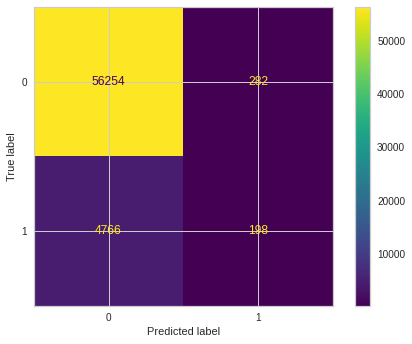

In [ ]:
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )


score, mc = evaluate(clf,
                  'lgbm',
                  X,
                  y,
                  k_fold=5,
                  beta=2,
                  show_confusion_matrice=True,
                  apply_undersampling=False,
                  apply_smote=False,
                  smote_params=None,
                  move_treshold=False,
                  treshold=None)

                   lgbm
f_beta_score_  0.420850
precision_     0.698720
recall_        0.681329
accuracy_      0.698720


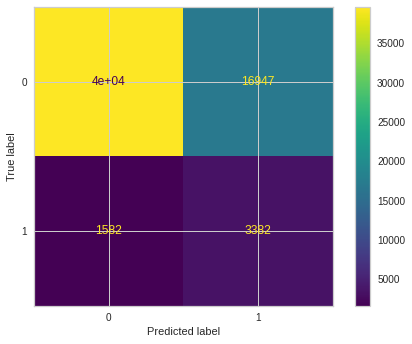

In [13]:
clf = LGBMClassifier(is_unbalance=True)


score, mc = evaluate(clf,
                  'lgbm',
                  X,
                  y,
                  k_fold=5,
                  beta=2,
                  show_confusion_matrice=True,
                  apply_undersampling=False,
                  apply_smote=False,
                  smote_params=None,
                  move_treshold=False,
                  treshold=None)
print(score)

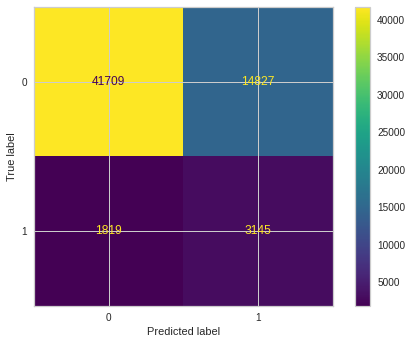

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=10)
score, mc = evaluate(xgb,
                  'xgb',
                  X,
                  y,
                  k_fold=5,
                  beta=2,
                  show_confusion_matrice=True,
                  apply_undersampling=False,
                  apply_smote=False,
                  smote_params=None,
                  move_treshold=False,
                  treshold=None)

In [ ]:
display(score)

,xgb
f_beta_score_,0.415747
precision_,0.729330
recall_,0.633595
accuracy_,0.729330


In [7]:
params = {
        'gamma': [0.5, 2, 5],
        'scale_pos_weight': [8, 9, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        }


In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

score, params = make_grisearch(xgb, X, y, param_grid=params)
print(score, params)

0.41840701174337075 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 4, 'scale_pos_weight': 10, 'subsample': 1.0}


                    xgb
f_beta_score_  0.418020
precision_     0.732501
recall_        0.633797
accuracy_      0.732501


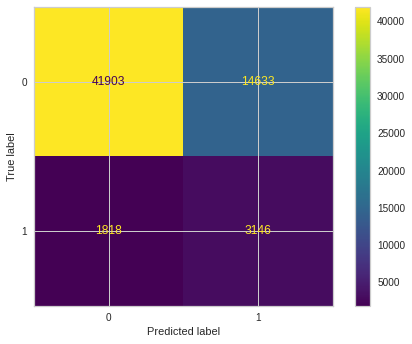

In [16]:
xgb = XGBClassifier(colsample_bytree =1.0, gamma= 0.5, max_depth= 4, scale_pos_weight= 10, subsample= 1.0)
score, mc = evaluate(xgb,
                  'xgb',
                  X,
                  y,
                  k_fold=5,
                  beta=2,
                  show_confusion_matrice=True,
                  apply_undersampling=False,
                  apply_smote=False,
                  smote_params=None,
                  move_treshold=False,
                  treshold=None)
print(score)